HW: https://github.com/DataTalksClub/llm-zoomcamp/blob/main/cohorts/2025/0a-agents/homework.md#mcp

In this HW, I used jupyter notebook with UV
UV is an extremely fast Python package and project manager, written in Rust.

Preparation
First, we'll define a function that we will use when building our agent.

It will generate fake weather data:

In [19]:
import random

known_weather_data = {
    'berlin': 20.0
}

def get_weather(city: str) -> float:
    city = city.strip().lower()

    if city in known_weather_data:
        return known_weather_data[city]

    return round(random.uniform(-5, 35), 1)

Q1. Define function description
We want to use it as a tool for our agent, so we need to describe it

How should the description for this function look like? Fill in missing parts

In [20]:
get_weather_tool = {
    "type": "function",
    "name": "get_weather",
    "description": "Gets the temperature for a specified city",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "The name of the city, e.g. New York"
            }
        },
        "required": ["city"],
        "additionalProperties": False
    }
}

Q1: What did you put in TODO3?
Answer: "<TODO3>" = "city"

Q2. Adding another tool
Let's add another tool - a function that can add weather data to our database

In [21]:
def set_weather(city: str, temp: float) -> None:
    city = city.strip().lower()
    known_weather_data[city] = temp
    return 'OK'

Now let's write a description for it.
What did you write?
Optionally, you can test it after adding this function.

Q2 Answer:

In [22]:
set_weather_tool = {
  "type": "function",
  "name": "set_weather",
  "description": "Updates the current weather temperature for a specific city.",
  "parameters": {
    "type": "object",
    "properties": {
      "city": {
        "type": "string",
        "description": "The name of the city, for example, 'New York' or 'London'."
      },
      "temp": {
        "type": "number",
        "description": "The temperature value to set, e.g., 20. The unit (Celsius, Fahrenheit) is determined by the tool's implementation."
      }
    },
    "required": ["city", "temp"],
    "additionalProperties": False
  }
}

MCP stands for Model-Context Protocol. It allows LLMs communicate with different tools (like Qdrant). It's function calling, but one step further:

A tool can export a list of functions it has
When we include the tool to our Agent, we just need to include the link to the MCP server

Q3. Install FastMCP
Let's install a library for MCP - FastMCP: 
(Added `fastmcp` in the pyproject.toml -> then I run `uv sync` (to install the libraries)

What's the version of FastMCP you installed?

In [23]:
import fastmcp
!fastmcp --version

2.11.3


Q3 Answer: "2.11.3"

Q4. Simple MCP Server

Let's change the example for our case and run it

What do you see in the output?

Look for a string that matches this template:

Starting MCP server 'Demo 🚀' with transport `<TODO>`

What do you have instead of `<TODO>`?

Q4 Asnwer: Starting MCP server 'Demo 🚀' with transport 'stdio' 

Please see below screenshot:
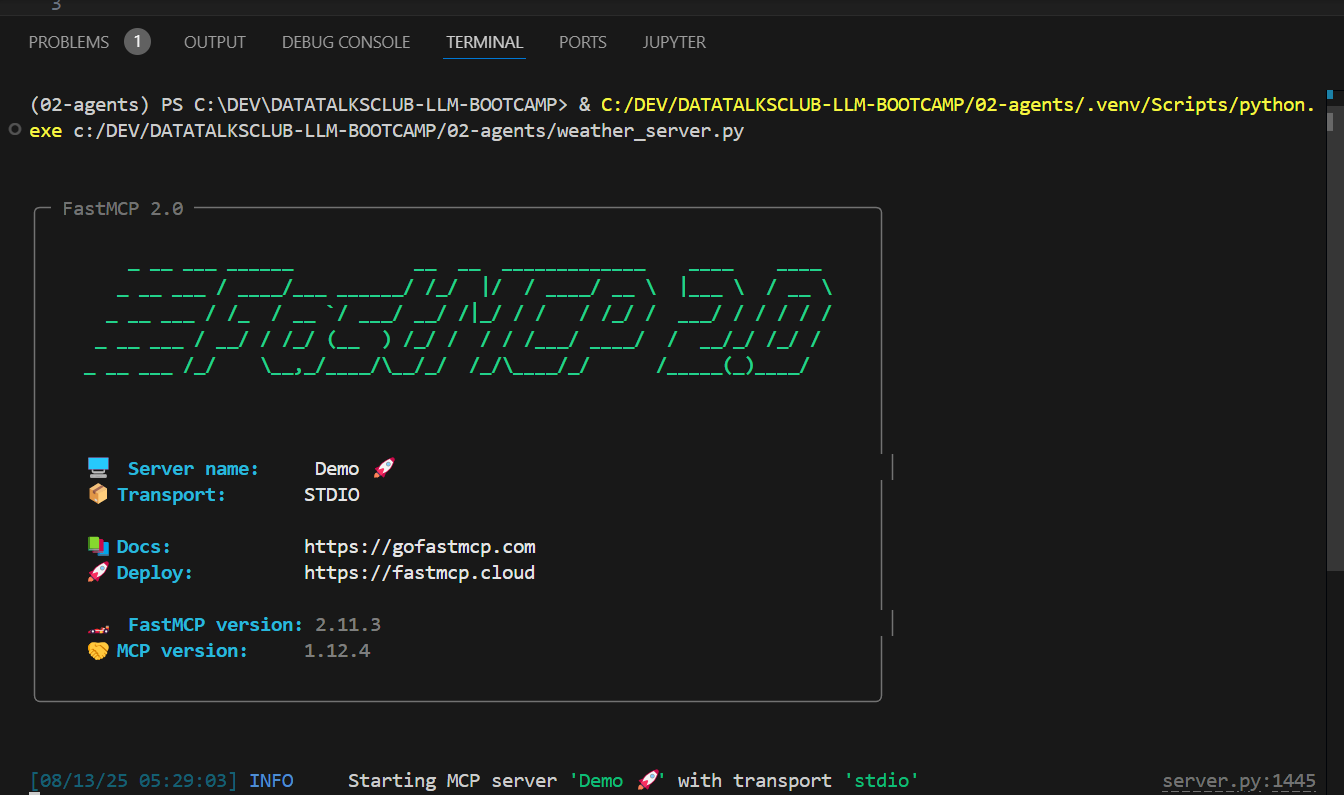

Q5. Protocol

There are different ways to communicate with an MCP server. Ours is currently running using standart input/output, which means that the client write something to stdin and read the answer using stdout.

Our weather server is currently running.

This is how we start communitcating with it:

First, we send an initialization request -- this way, we register our client with the server:

```json
{'"jsonrpc": "2.0", "id": 1, "method": "initialize", "params": {"protocolVersion": "2024-11-05", "capabilities": {"roots": {"listChanged": true}, "sampling": {}}, "clientInfo": {"name": "test-client", "version": "1.0.0"}}}
```
We should get back something like that, which is an aknowledgement of the request:

```json
{"jsonrpc":"2.0","id":1,"result":{"protocolVersion":"2024-11-05","capabilities":{"experimental":{},"prompts":{"listChanged":false},"resources":{"subscribe":false,"listChanged":false},"tools":{"listChanged":true}},"serverInfo":{"name":"Demo 🚀","version":"1.9.4"}}}
```

Next, we reply back, confirming the initialization:

```json
{"jsonrpc": "2.0", "method": "notifications/initialized"}
```

We don't expect to get anything in response

Now we can ask for a list of available methods:

```json
{"jsonrpc": "2.0", "id": 2, "method": "tools/list"}
```

Let's ask the temperature in Berlin:

```json
{"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "<TODO>", "arguments": {<TODO>}}}
```
What did you get in response?


Q5 Answer:
- Let's ask the temperature in Berlin:
```json
{"jsonrpc": "2.0", "id": 3, "method": "tools/call", "params": {"name": "get_weather", "arguments": {"city":"berlin"}}}
```
- What did you get in response?
```json
{"jsonrpc":"2.0","id":3,"result":{"content":[{"type":"text","text":"20.0"}],"structuredContent":{"result":20.0},"isError":false}}
```

Please see below screenshot:
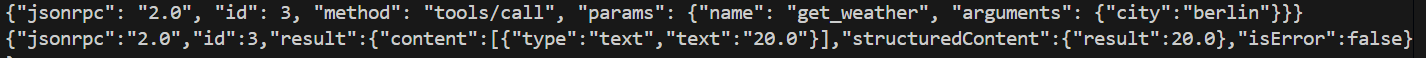


Q6. Client
We typically don't interact with the server by copy-pasting commands in the terminal.

In practice, we use an MCP Client. Let's implement it.

FastMCP also supports MCP clients:

In [17]:
import asyncio
import weather_server
from fastmcp import Client

async def main():
    async with Client(weather_server.mcp) as mcp_client:
        tools = await mcp_client.list_tools()
        return tools

tools = await main()
print (tools)

[Tool(name='add', title=None, description='Add two numbers', inputSchema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'integer'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta={'_fastmcp': {'tags': []}}), Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, anno

Q6 Answer: 
```python
[Tool(name='add', title=None, description='Add two numbers', inputSchema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'integer'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta={'_fastmcp': {'tags': []}}), Tool(name='get_weather', title=None, description='Retrieves the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to retrieve weather data.\n\nReturns:\n    float: The temperature associated with the city.', inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}}, 'required': ['city'], 'type': 'object'}, outputSchema={'properties': {'result': {'title': 'Result', 'type': 'number'}}, 'required': ['result'], 'title': '_WrappedResult', 'type': 'object', 'x-fastmcp-wrap-result': True}, annotations=None, meta={'_fastmcp': {'tags': []}}), Tool(name='set_weather', title=None, description="Sets the temperature for a specified city.\n\nParameters:\n    city (str): The name of the city for which to set the weather data.\n    temp (float): The temperature to associate with the city.\n\nReturns:\n    str: A confirmation string 'OK' indicating successful update.", inputSchema={'properties': {'city': {'title': 'City', 'type': 'string'}, 'temp': {'title': 'Temp', 'type': 'number'}}, 'required': ['city', 'temp'], 'type': 'object'}, outputSchema=None, annotations=None, meta={'_fastmcp': {'tags': []}})]
```

In [18]:
for tool in tools:
    print(f"- Name: {tool.name}")
    print(f"  Description: {tool.description}")
    print("-" * 20)  # A separator for readability


- Name: add
  Description: Add two numbers
--------------------
- Name: get_weather
  Description: Retrieves the temperature for a specified city.

Parameters:
    city (str): The name of the city for which to retrieve weather data.

Returns:
    float: The temperature associated with the city.
--------------------
- Name: set_weather
  Description: Sets the temperature for a specified city.

Parameters:
    city (str): The name of the city for which to set the weather data.
    temp (float): The temperature to associate with the city.

Returns:
    str: A confirmation string 'OK' indicating successful update.
--------------------
